In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, HalvingRandomSearchCV, StratifiedKFold,PredefinedSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix, plot_roc_curve

In [2]:
inlocal = True

In [2]:
if not inlocal:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
if inlocal:
  train = pd.read_csv('../data/cleaned/train.csv')
  val = pd.read_csv('../data/cleaned/val.csv')
  test = pd.read_csv('../data/cleaned/test.csv')
else: 
  train = pd.read_csv('/content/drive/MyDrive/projectML/Data/train.csv')
  val = pd.read_csv('/content/drive/MyDrive/projectML/Data/val.csv')
  test = pd.read_csv('/content/drive/MyDrive/projectML/Data/test.csv')

target = 'Credit_Score'
X_train, y_train = train.drop(target, axis=1), train[target]
X_val, y_val = val.drop(target, axis=1), val[target]
X_test, y_test = test.drop(target, axis=1), test[target]

print('Train set: ', X_train.shape, y_train.shape)
print('Validation set: ', X_val.shape, y_val.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (74997, 55) (74997,)
Validation set:  (15003, 55) (15003,)
Test set:  (10000, 55) (10000,)


In [4]:
col_transformer = ColumnTransformer([
    ('num', StandardScaler(), X_train.select_dtypes(include=np.float64).columns),
], remainder='passthrough')
X_train = col_transformer.fit_transform(X_train)
X_val = col_transformer.transform(X_val)
X_test = col_transformer.transform(X_test)

In [5]:
def create_pipeline_1():
    return imbPipeline([
        ('sampling', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

## Search for k_neighbors in smote

In [ ]:
# search for k_neighbors in smote
params_1 = {
    'sampling__k_neighbors': [3, 5, 7, 10, 15, 20, 30, 50, 70, \
        90, 100, 120, 150, 200, 300, 400, 800], 
}
search = GridSearchCV(
    create_pipeline_1(), 
    params_1, 
    cv=PredefinedSplit(test_fold=np.concatenate([np.full(len(X_train), -1), np.zeros(len(X_val))])),
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1,
    refit=False
)

search.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

Fitting 1 folds for each of 17 candidates, totalling 17 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=Pipeline(steps=[('sampling', SMOTE(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'sampling__k_neighbors': [3, 5, 7, 10, 15, 20, 30, 50,
                                                   70, 90, 100, 120, 150, 200,
                                                   300, 400, 800]},
             refit=False, scoring='accuracy', verbose=1)

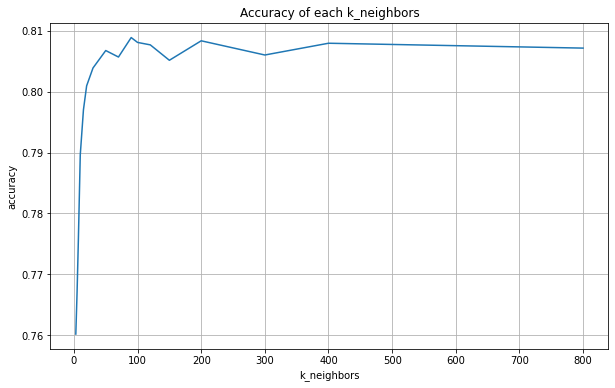

In [ ]:
# plot the accuracy of each k_neighbors
plt.figure(figsize=(10, 6))
plt.plot(pd.DataFrame(search.cv_results_)['param_sampling__k_neighbors'], pd.DataFrame(search.cv_results_)['mean_test_score'])
plt.title('Accuracy of each k_neighbors')
plt.grid(True)
plt.xlabel('k_neighbors')
plt.ylabel('accuracy')
plt.show()

In [ ]:
pd.DataFrame(search.cv_results_)[['param_sampling__k_neighbors', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False)

,param_sampling__k_neighbors,mean_test_score
9,90,0.808905
13,200,0.808372
10,100,0.808105
15,400,0.807972
11,120,0.807705
16,800,0.807172
7,50,0.806772
14,300,0.806039
8,70,0.805706
12,150,0.805172


In [ ]:
# Best k_neighbors for smote is 90

In [10]:
# sample 50% of train set to reduce search time in random search
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_train
)

## Search for hyperparameters in random forest

In [13]:
rf_params = {
    'sampling__k_neighbors': [90],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None],
    'classifier__min_samples_split': [2, 3, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 7, 10],
    'classifier__max_features': [6,7,8],
}
rf_rnd_search = RandomizedSearchCV(
    create_pipeline_1(), 
    rf_params,
    cv=PredefinedSplit(test_fold=np.concatenate([np.full(len(X_train_sample), -1), np.zeros(len(X_val))])),
    scoring='accuracy', 
    verbose=1, 
    random_state=42,
    refit=False,
    n_iter=100
)

In [ ]:
rf_rnd_search.fit(np.concatenate([X_train_sample, X_val]), np.concatenate([y_train_sample, y_val]))
print('Best params: ', rf_rnd_search.best_params_)
print('Best score: ', rf_rnd_search.best_score_)

In [18]:
pd.DataFrame(rf_rnd_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False).head(10)

,params,mean_test_score,std_test_score
73,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.783977,0.0
36,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.783110,0.0
77,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.781644,0.0
80,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.779977,0.0
70,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.779977,0.0
51,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.779711,0.0
16,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.779377,0.0
18,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.779311,0.0
53,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.778778,0.0
10,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.778378,0.0


In [20]:
rf_rnd_search.best_params_

{'sampling__k_neighbors': 90,
 'classifier__n_estimators': 200,
 'classifier__min_samples_split': 2,
 'classifier__min_samples_leaf': 1,
 'classifier__max_features': 8,
 'classifier__max_depth': None}

In [31]:
# retrain top 3 params on full train set and evaluate result
top3_rf_params = pd.DataFrame(rf_rnd_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False).head(3)['params'].values
for params in top3_rf_params:
    rf = create_pipeline_1()
    rf.set_params(**params)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    print('Params: ', params)
    print('Accuracy: ', accuracy_score(y_val, y_pred))
    print('---'*20, '\n\n')


Params:  {'sampling__k_neighbors': 90, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 8, 'classifier__max_depth': None}
Accuracy:  0.8076384723055389
------------------------------------------------------------ 


Params:  {'sampling__k_neighbors': 90, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 7, 'classifier__max_depth': None}
Accuracy:  0.8093714590415251
------------------------------------------------------------ 


Params:  {'sampling__k_neighbors': 90, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 7, 'classifier__max_depth': None}
Accuracy:  0.8084383123375325
------------------------------------------------------------ 




## Search for hyperparameters in Extratree

In [21]:
def create_pipeline_2():
    return imbPipeline([
        ('sampling', SMOTE(random_state=42)),
        ('classifier', ExtraTreesClassifier(random_state=42))
    ])

In [25]:
et_params = {
    'sampling__k_neighbors': [90],
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None],
    'classifier__min_samples_split': [2, 3, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 5, 7, 10],
    'classifier__max_features': [6,7,8],
}

et_rnd_search = RandomizedSearchCV(
    create_pipeline_1(), 
    et_params, 
    cv=PredefinedSplit(test_fold=np.concatenate([np.full(len(X_train_sample), -1), np.zeros(len(X_val))])),
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2, 
    n_iter=100, 
    random_state=42
)

In [26]:
et_rnd_search.fit(np.concatenate([X_train_sample, X_val]), np.concatenate([y_train_sample, y_val]))
pd.DataFrame(et_rnd_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,params,mean_test_score,std_test_score
73,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.783977,0.0
36,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.783110,0.0
77,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.781644,0.0
80,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.779977,0.0
70,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.779977,0.0
...,...,...,...
68,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.734320,0.0
28,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.734320,0.0
58,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.732454,0.0
57,"{'sampling__k_neighbors': 90, 'classifier__n_e...",0.732454,0.0


In [30]:
# retrain top 3 best params on full train set
top3_et_params = pd.DataFrame(et_rnd_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False).head(3)['params'].values
for params in top3_et_params:
    et = create_pipeline_2()
    et.set_params(**params)
    et.fit(X_train, y_train)
    y_pred = et.predict(X_val)
    print('Params: ', params)
    print('Accuracy: ', accuracy_score(y_val, y_pred))
    print('---'*20, '\n\n')


Params:  {'sampling__k_neighbors': 90, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 8, 'classifier__max_depth': None}
Accuracy:  0.8181696993934546
------------------------------------------------------------ 


Params:  {'sampling__k_neighbors': 90, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 7, 'classifier__max_depth': None}
Accuracy:  0.8169699393454642
------------------------------------------------------------ 


Params:  {'sampling__k_neighbors': 90, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 7, 'classifier__max_depth': None}
Accuracy:  0.8151036459374792
------------------------------------------------------------ 




{'sampling__k_neighbors': 90,
 'classifier__n_estimators': 200,
 'classifier__min_samples_split': 2,
 'classifier__min_samples_leaf': 1,
 'classifier__max_features': 8,
 'classifier__max_depth': None}

### Evaluate on test set

In [37]:
def report(model_name, y_test, y_pred):
  print('Report for', model_name, ':\n\n', classification_report(y_test, y_pred))
  # plot confusion matrix
  cm = confusion_matrix(y_test, y_pred, normalize='true')
  plt.figure(figsize=(10, 10))
  sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
  plt.title('Confusion matrix for ' + model_name)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  print('Accuracy: ', accuracy_score(y_test, y_pred))
  print('-'*60)
  print('\n\n\n')

In [ ]:
# Random Forest

rf = create_pipeline_1()
rf.set_params(
    sampling__k_neighbors=90,
    classifier__n_estimators=200,
    classifier__max_depth=None,
    classifier__min_samples_split=2,
    classifier__min_samples_leaf=1,
    classifier__max_features=7
)
rf.fit(X_train, y_train)

Report for Random Forest :

               precision    recall  f1-score   support

           0       0.79      0.85      0.82      2900
           1       0.85      0.79      0.82      5317
           2       0.74      0.80      0.77      1783

    accuracy                           0.81     10000
   macro avg       0.79      0.81      0.80     10000
weighted avg       0.81      0.81      0.81     10000



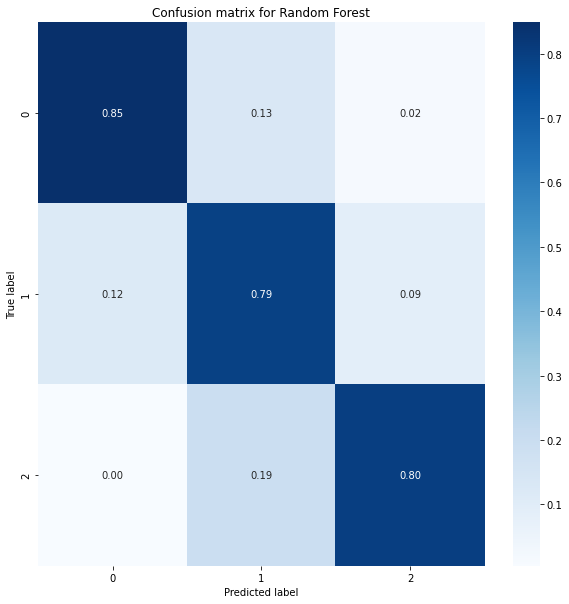

Accuracy:  0.8109
------------------------------------------------------------






In [38]:
y_pred = rf.predict(X_test)
report('Random Forest', y_test, y_pred)

In [ ]:
# Extra Trees

et = create_pipeline_2()
et.set_params(
    sampling__k_neighbors=90,
    classifier__n_estimators=200,
    classifier__max_depth=None,
    classifier__min_samples_split=2,
    classifier__min_samples_leaf=1,
    classifier__max_features=8,
)
et.fit(X_train, y_train)

Report for Extra Trees :

               precision    recall  f1-score   support

           0       0.80      0.85      0.82      2900
           1       0.85      0.81      0.83      5317
           2       0.77      0.82      0.80      1783

    accuracy                           0.82     10000
   macro avg       0.81      0.83      0.82     10000
weighted avg       0.82      0.82      0.82     10000



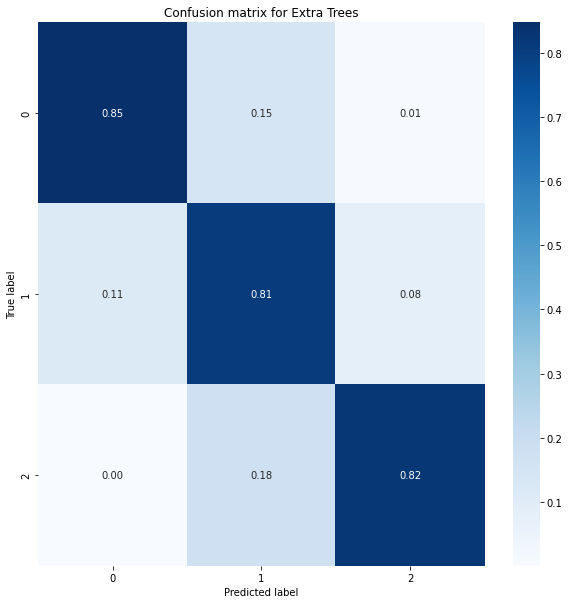

Accuracy:  0.822
------------------------------------------------------------






In [39]:
y_pred = et.predict(X_test)
report('Extra Trees', y_test, y_pred)